<a href="https://colab.research.google.com/github/Devansh-Vaidya/FeatureMatching/blob/main/COMP478.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Processing - Feature Matching

## Introduction

<p>Feature matching is a crucial task in image processing and computer vision, and this project focuses on developing an algorithm that can accurately match features between two images. To match and detect features between two images using SIFT, RANSAC, and homography matrix, the following steps are typically taken:</p>

<ol>
<li>Extract SIFT keypoints and descriptors from both images.</li>
<li>Use a matching algorithm to find potential matches between the keypoints in the two images.</li>
<li>Apply RANSAC to estimate the homography matrix that best aligns the two images.</li>
<li>Use the homography matrix to transform the keypoints in one image to the coordinate system of the other image.</li>
<li>Remove outliers using RANSAC and re-estimate the homography matrix if necessary.</li>
<li>Use the transformed keypoints to stitch the two images together or perform other tasks such as object recognition or 3D reconstruction.</li>
</ol>

## Feature Matching
Matching the corresponding features extracted from the images to the given image template.

### Import Python Modules
Importing necessary modules used for feature matching.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, SIFT
from skimage.util import img_as_float
!git clone "https://github.com/Devansh-Vaidya/FeatureMatching.git"

Cloning into 'FeatureMatching'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 6), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (25/25), 853.77 KiB | 3.30 MiB/s, done.


### Utility Functions
Helper functions to display input images, feature matching and outline box for the object.**bold text**

In [ ]:
# Displays the input images
def show_images(img1, img2, img3):
    plt.subplot(1, 3, 1)
    plt.imshow(img1, cmap='gray')
    plt.title("Book 1")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img2, cmap='gray')
    plt.title("Book 2")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img3, cmap='gray')
    plt.title("Scattered Books")
    plt.axis('off')
    plt.show()

# Displays the keypoints of the input images
def show_sift_keypoints(template, target, locs1, locs2):
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(locs1[:, 1], locs1[:, 0], 'o', markerfacecolor='none', markersize=1, markeredgecolor='r')
    plt.title("Template Keypoints")
    ax1.imshow(template, cmap='gray')
    ax2 = plt.subplot(1, 2, 2)
    plt.title("Target Keypoints")
    ax2.imshow(target, cmap='gray')
    ax2.plot(locs2[:, 1], locs2[:, 0], 'o', markerfacecolor='none', markersize=1, markeredgecolor='r')
    plt.show()

# Displays matching keypoints between 2 images
def show_image_match(template, target, locs1, locs2, matches):
    n_rows1, n_cols1 = template.shape[:2]
    n_rows2 = target.shape[0]
    # pad the template image with zeros
    template = np.pad(template, ((0, n_rows2 - n_rows1), (0, 0)))

    # Stack the template and target images horizontally
    img = np.hstack((template, target))

    # Extract the x and y coordinates of matched features from both images
    i1 = matches[:, 0]
    i2 = matches[:, 1]
    x1 = locs1[i1, 1]
    y1 = locs1[i1, 0]
    x2 = locs2[i2, 1] + n_cols1
    y2 = locs2[i2, 0]

    # Show the resulting image and the plot
    plt.title("SIFT Descriptor Matching")
    plt.imshow(img, cmap='gray')
    plt.plot([x1, x2], [y1, y2])
    plt.show()

# Displays outline of the matching image
def show_outline_box(template, target, H):
    n_rows, n_cols = template.shape[:2]
    row = np.array([0, 0, n_rows - 1, n_rows - 1, 0]).astype(float)
    col = np.array([0, n_cols - 1, n_cols - 1, 0, 0]).astype(float)

    # Get the coordinates from the homogeneous matrix to draw a box for the image
    w = H[2, 0]*col + H[2, 1]*row + H[2, 2]
    x = np.rint((H[0, 0]*col + H[0, 1]*row + H[0, 2]) / w)
    y = np.rint((H[1, 0]*col + H[1, 1]*row + H[1, 2]) / w)

    # Show the resulting image and the plot
    plt.imshow(target)
    plt.plot(x, y, 'r-')
    plt.show()

### Image Matching
This function takes 2 images and uses SIFT detector on it to match local features and extract the keypoints.

In [ ]:
def sift_match(I1, I2):
    # Initialize SIFT descriptor object
    sift_desc = SIFT()

    # Detect and extract keypoints and descriptors from the two images
    sift_desc.detect_and_extract(I1)
    locs1 = sift_desc.keypoints
    descs1 = sift_desc.descriptors
    sift_desc.detect_and_extract(I2)
    locs2 = sift_desc.keypoints
    descs2 = sift_desc.descriptors

    # Match descriptors between the two images using ratio test and cross-checking
    matches = match_descriptors(descs1, descs2, max_ratio=0.75,
                                cross_check=True)

    # Return the matches and the locations of keypoints in both images
    return matches, locs1, locs2

### Compute Homography
This function computes best homography matrix for the given keypoints using RANSAC.

In [ ]:
def computeH_ransac(matches, locs1, locs2):
    inliers = np.zeros((0, 2))
    best_homography = None
    THRESHOLD = 0.75

    # Computing RANSAC for different matching points
    for i in range(500):
        # Selecting 4 random points
        points = matches[np.random.choice(matches.shape[0], 4, replace=False)]

        # Computing homography using the 4 points from matches
        A = np.zeros((points.shape[0] * 2, 9))
        for i in range(points.shape[0]):
            y1, x1 = locs1[points[i, 0], :]
            y2, x2 = locs2[points[i, 1], :]
            A[i * 2, :] = [-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2]
            A[i * 2 + 1, :] = [0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2]
        U, S, Vt = np.linalg.svd(A)
        H = np.reshape(Vt[8], (3, 3))
        
        # Compute the inliers using the homography
        N = []
        for i in range(len(matches)):
            p1 = np.transpose(
                np.matrix([locs1[matches[i, 0], 1], locs1[matches[i, 0], 0], 1]))
            p2 = np.transpose(
                np.matrix([locs2[matches[i, 1], 1], locs2[matches[i, 1], 0], 1]))
            estimatep2 = np.dot(H, p1)
            estimatep2 = estimatep2/estimatep2[2]
            error = p2 - estimatep2
            d = np.linalg.norm(error)

            if d < 0.5:
                N.append(i)

        # Update best_homography and inliers if this homography has more inliers than the current best homography
        if len(N) > len(inliers):
            inliers = N
            best_homography = H

        # Stop RANSAC if the number of inliers exceeds the threshold
        if len(inliers) > (len(matches) * THRESHOLD):
            break

    return best_homography, inliers

### Read Images
Loading and displaying images from GitHub Repository.

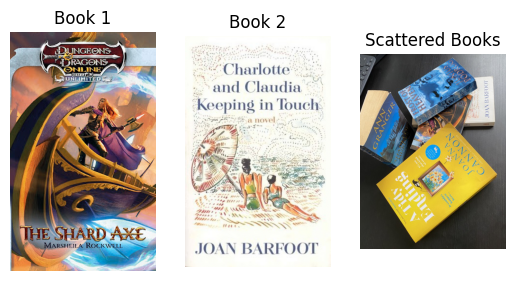

In [ ]:
# Loading and storing the images as rgb and greyscale
cover_image = img_as_float(io.imread('/content/FeatureMatching/images/book_cover.jpg'))
cover_image_grey = rgb2gray(cover_image)
cover_image2 = img_as_float(io.imread('/content/FeatureMatching/images/book_cover2.jpg'))
cover_image_grey2 = rgb2gray(cover_image2)
books_image = img_as_float(io.imread('/content/FeatureMatching/images/multiple_books.jpeg'))
books_image_grey = rgb2gray(books_image)

# Display the input images
show_images(cover_image, cover_image2, books_image)

### Find matches between 2 images
Using SIFT detector to find matching keypoints and displaying the raw result.
<ul>
<li>Match between book 1 and book with obstruction</li>
<li>Match between book 1 and multiple books with obstruction</li>
<li>Match between book 2 and multiple books with obstruction</li>
</ul>

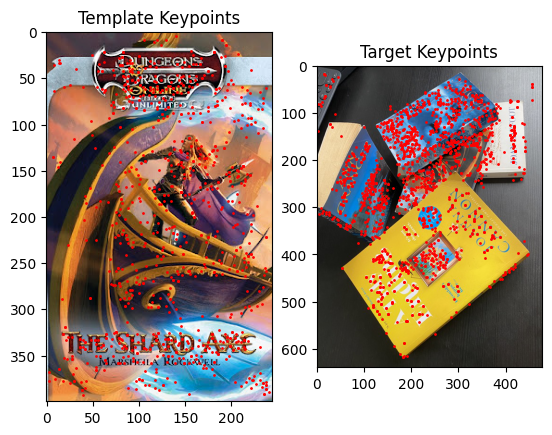

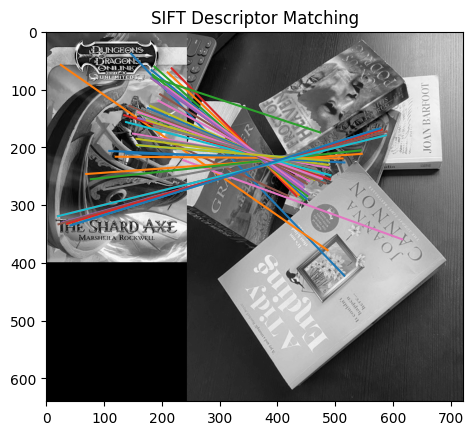

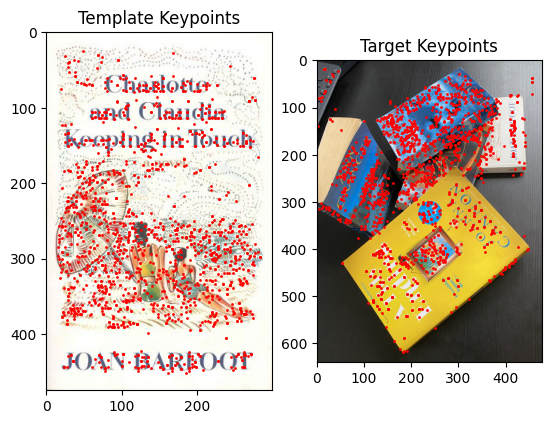

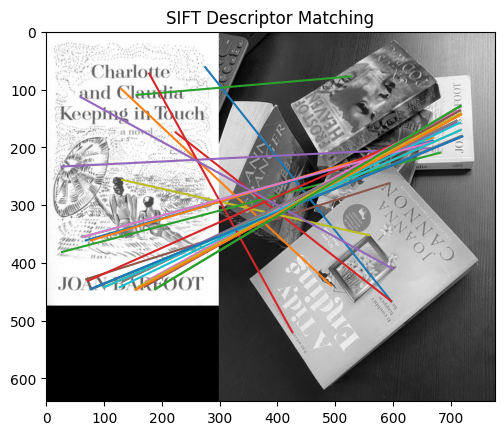

In [ ]:
# Find candidate matching pairs between two images and display raw matching result
matches, locs1, locs2 = sift_match(cover_image_grey, books_image_grey)
show_sift_keypoints(cover_image, books_image, locs1, locs2)
show_image_match(cover_image_grey, books_image_grey, locs1, locs2, matches)

matches2, locs3, locs4 = sift_match(cover_image_grey2, books_image_grey)
show_sift_keypoints(cover_image2, books_image, locs3, locs4)
show_image_match(cover_image_grey2, books_image_grey, locs3, locs4, matches2)

### RANSAC and Homography Matrix
Applying RANSAC on keypoints from SIFT detector to detect robust keypoints and finding corresponding homography matrix. Displaying the results of feature matching and bounding box of the object.

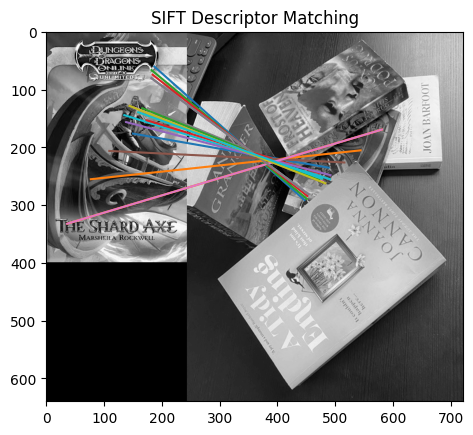

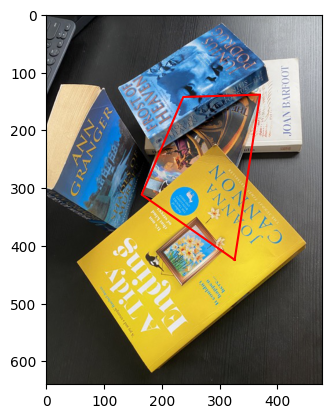

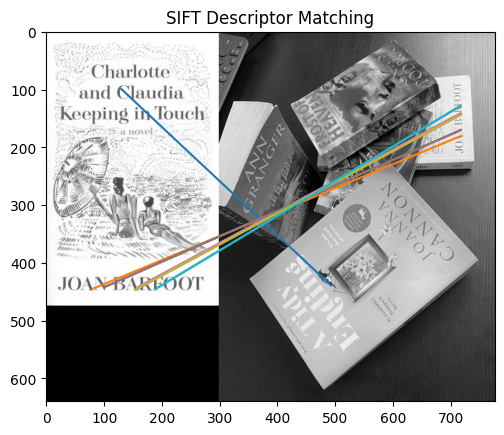

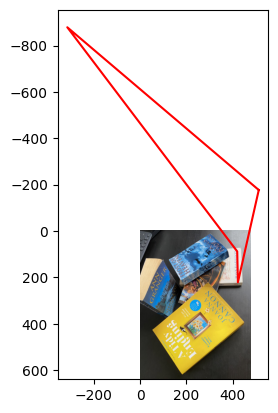

In [ ]:
# Use RANSAC to estimate homograhy and find inlier matches
best_homography1, inliers1 = computeH_ransac(matches, locs1, locs2)
best_homography2, inliers2 = computeH_ransac(matches2, locs3, locs4)

# Display matching result and bounding box for book 1
show_image_match(cover_image_grey, books_image_grey, locs1, locs2, matches[inliers1, :])
show_outline_box(cover_image, books_image, best_homography1)

# Display matching result and bounding box for book 2
show_image_match(cover_image_grey2, books_image_grey, locs3, locs4, matches2[inliers2, :])
show_outline_box(cover_image2, books_image, best_homography2)

## References:
<ol>
<li><a href="https://github.com/hughesj919/HomographyEstimation">GitHub (Jordan Hughes) - Homography Estimation</a></li>
<li><a href="https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html" target="_blank">
         SIFT feature detector and descriptor extractor</a></li>
</ol>


